# Experimentation with LDM sample-implementation

In [125]:
from typing import Literal
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.utils as utils
import scipy.sparse as sp
from scipy.sparse.linalg import svds, eigsh
import torch.nn as nn
import torch_geometric


class LatentDistanceModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(LatentDistanceModel, self).__init__()
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, sampled_nodes):
        # Get embeddings only for the sampled nodes
        z_sampled = self.embeddings(sampled_nodes)

        # Compute pairwise distances between the sampled nodes
        dist_matrix = torch.cdist(z_sampled, z_sampled, p=2)  # Shape: [m, m]

        return dist_matrix
    
    def node_position_init(self, data, method):
        """
        Initializes the node embeddings using truncated SVD of the sparse adjacency matrix.
        
        Parameters:
        - data: PyTorch Geometric Data object with edge_index (graph structure).
        """
        num_nodes = data.num_nodes
        row, col = data.edge_index
        adj_matrix_sparse = sp.coo_matrix(
            (torch.ones_like(row).numpy().astype(np.float32),
            (row.numpy(), col.numpy())), 
                                          shape=(num_nodes, num_nodes))

        if method == 'eigen':
            _, eig_vect = eigsh(
                adj_matrix_sparse,
                self.embeddings.embedding_dim,
                which='LM'
            )
            U = eig_vect.real

        elif method == 'SVD':
            U, _, _ = svds(adj_matrix_sparse, k=self.embeddings.embedding_dim)
        else:
            print('Not method provided for initial node positions. Skipping initialization.')
            return

        #rows_norm = np.linalg.norm(U, axis=1, ord=2)
        #rows_norm[rows_norm == 0] = 10**(-9)

        #U = (U.T / rows_norm).T

        self.embeddings.weight.data = torch.tensor(U.copy(), dtype=torch.float)

In [126]:
def poisson_link_prob(distance):
    # Link probability following a Poisson distribution
    return torch.exp(-distance)

In [127]:
def poisson_reconstruction_loss(distances, edge_index, num_nodes):
    """
    Computes the Poisson reconstruction loss based on the distances between nodes.
    Arguments:
    - distances: tensor of distances between node pairs.
    - edge_index: edge list for the subgraph (indicating observed edges).
    - num_nodes: total number of nodes in the graph.
    """
    # Compute Poisson rate (lambda) for all pairs based on distances
    predicted_lambdas = poisson_link_prob(distances)

    # Mask for edges and non-edges
    edges_mask = torch.zeros((num_nodes, num_nodes), dtype=torch.bool)
    edges_mask[edge_index[0], edge_index[1]] = 1  # Set mask to 1 where edges exist

    # Loss for actual edges: maximize log-likelihood of seeing an edge
    edge_loss = -torch.log(predicted_lambdas[edges_mask] + 1e-6).mean()

    # Loss for non-edges: minimize log-likelihood of non-edges
    non_edge_loss = -torch.log(1 - predicted_lambdas[~edges_mask] + 1e-6).mean()

    # Total loss
    return edge_loss + non_edge_loss


In [128]:
import torch_geometric.utils as utils

def sample_induced_subgraph(data, m):
    """
    Randomly samples a subset of nodes and returns the induced subgraph.
    
    Parameters:
    - data: Full graph data object.
    - m: Number of nodes to sample in each batch.
    
    Returns:
    - sampled_nodes: The list of randomly sampled node indices.
    - subgraph_edge_index: The remapped edge index for the sampled nodes.
    """
    # Randomly sample m nodes
    sampled_nodes = torch.randperm(data.num_nodes)[:m]

    # Create the induced subgraph for the sampled nodes, relabel nodes to range [0, m-1]
    subgraph_edge_index, _ = utils.subgraph(sampled_nodes, data.edge_index, relabel_nodes=True)

    return sampled_nodes, subgraph_edge_index


In [129]:
import torch
import torch_geometric.utils as utils

def ladies_sample(data, m, layers=2):
    """
    Performs LADIES sampling to select a batch of nodes and create an induced subgraph.
    
    Parameters:
    - data: Full graph data object.
    - m: Number of nodes to sample in the final batch.
    - layers: Number of layers in the GCN model, indicating how many layers of neighbors to sample.
    
    Returns:
    - sampled_nodes: Final list of sampled node indices.
    - subgraph_edge_index: The induced subgraph's edge index.
    """
    # Step 1: Randomly sample the initial batch of nodes
    sampled_nodes = torch.randperm(data.num_nodes)[:m]

    # Step 2: Iteratively sample neighbors of the sampled nodes
    for _ in range(layers):
        neighbors = set()
        for node in sampled_nodes:
            neighbors.update(data.edge_index[1][data.edge_index[0] == node].tolist())
        neighbors = torch.tensor(list(neighbors), dtype=torch.long)

        # Merge the sampled nodes with their neighbors
        sampled_nodes = torch.cat([sampled_nodes, neighbors]).unique()

    # Step 3: Create an induced subgraph for the sampled nodes
    subgraph_edge_index, _ = utils.subgraph(sampled_nodes, data.edge_index, relabel_nodes=True)
    
    return sampled_nodes, subgraph_edge_index


In [130]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric.utils as utils
import matplotlib.pyplot as plt

def generate_grid_graph(n):
    # Create an n x n grid graph using networkx
    G = nx.grid_2d_graph(n, n)
    
    # Relabel nodes as integers (from (i, j) to a single integer)
    mapping = {(i, j): i * n + j for i, j in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    
    # Get edge list from networkx
    edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
    
    # Since grid graph nodes have no features, we can set them to a placeholder (e.g., zeros)
    x = torch.zeros((n * n, 1))  # n * n nodes, 1 feature per node (placeholder)
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)
    
    return data

In [143]:
import torch
import torch.optim as optim
from torch_geometric.data import Data

# Generate an n x n grid graph
n = 35  # Grid size
data = generate_grid_graph(n)
num_nodes = n * n

# Define model, optimizer, and training settings
embedding_dim = 2  # Latent embedding dimension
model = LatentDistanceModel(num_nodes, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Simple Adam optimizer
num_epochs = 10*num_nodes  # Number of training epochs

m = int(num_nodes/100)

In [135]:
model.node_position_init(data, method='eigen')

In [151]:
mean_loss = 0
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    shuffled_nodes = torch.randperm(num_nodes)
    node_batches = [shuffled_nodes[i:i + m] for i in range(0, num_nodes, m)]

    mean_loss = 0 

    sampled_nodes, subgraph_edge_index = ladies_sample(data, m, layers=2)
    # Forward pass: Compute the predicted distances between node pairs
    dist_matrix = model(sampled_nodes)

    # Compute the Poisson reconstruction loss
    loss = poisson_reconstruction_loss(dist_matrix, subgraph_edge_index, len(sampled_nodes))

    # Backward pass: Compute gradients and update parameters
    loss.backward()
    optimizer.step()

    mean_loss += loss.item()

    # Print loss for each epoch
    if epoch % num_nodes == 0:
        mean_loss /= num_nodes
        print(f'Epoch {int(epoch/num_nodes) + 1}/{int(num_epochs/num_nodes)}, Mean loss: {mean_loss:.4f}')
        mean_loss = 0

Epoch 1/200, Mean loss: 0.0020
Epoch 2/200, Mean loss: 0.0008
Epoch 3/200, Mean loss: 0.0007
Epoch 4/200, Mean loss: 0.0007
Epoch 5/200, Mean loss: 0.0006
Epoch 6/200, Mean loss: 0.0006
Epoch 7/200, Mean loss: 0.0006


KeyboardInterrupt: 

In [138]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_embeddings(model, n):
    """
    Visualizes the graph structure with node positions based on the learned 2D embeddings.
    
    Parameters:
    - model: Trained LatentDistanceModel.
    - data: The graph data.
    """
    # Extract learned 2D embeddings
    with torch.no_grad():  # No need to compute gradients during visualization
        embeddings = model.embeddings.weight.cpu().numpy()  # Shape: [num_nodes, 2]

    # Create the original grid graph using networkx
    G = nx.grid_2d_graph(n, n)

    # Relabel nodes to match embedding indices (convert 2D grid positions to single integers)
    mapping = {(i, j): i * n + j for i, j in G.nodes()}
    G = nx.relabel_nodes(G, mapping)

    # Create a dictionary mapping node indices to their 2D embedding positions
    pos = {i: embeddings[i] for i in range(n * n)}

    # Plot the graph using the learned 2D embeddings as node positions
    plt.figure(figsize=(8, 8))
    nx.draw(G,
            pos,
            with_labels=False,
            node_color='lightblue',
            node_size=10,
            font_size=10,
            edge_color='gray')
    
    # Show the plot
    plt.title("Graph Visualization with Learned 2D Embeddings")
    plt.show()

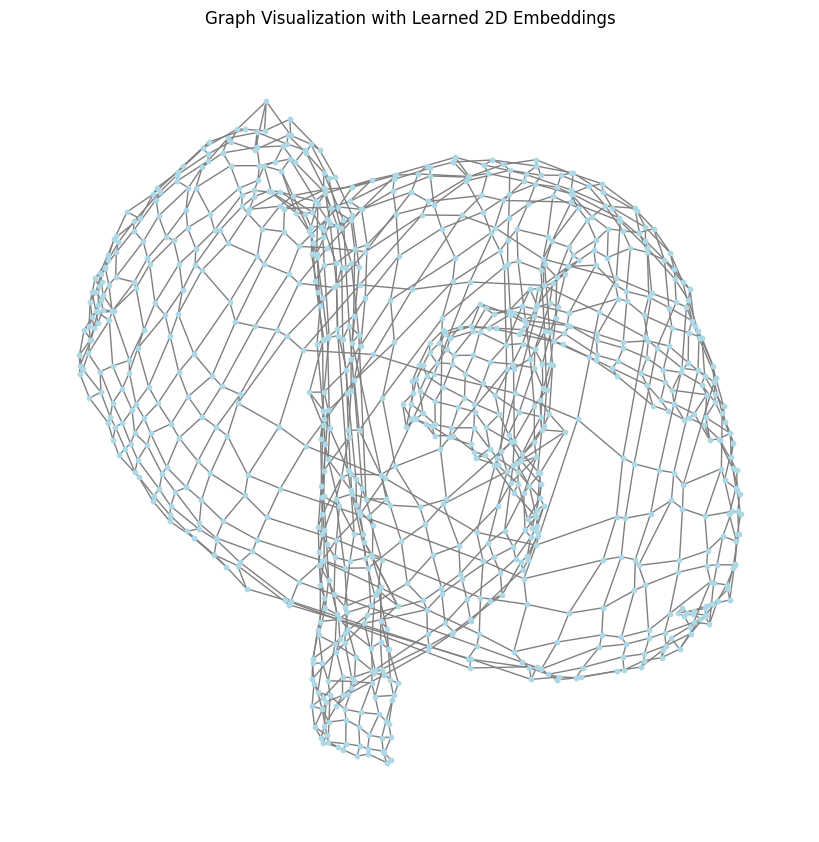

In [ ]:
# Example usage
visualize_embeddings(model, n=n)